The following code reproduces Figure 3 from the manuscript, containing the following: 

1990-2021 Southern Ocean SST trends in models and observations. The transient SST response to historical freshwater forcings ($F_{(P-E)}$ and $F_{melt}$, see Fig. 2d) are shown in (a) for Antarctic meltwater ($SST_{melt}(t)$, green curve) and the observed-simulated difference in enhanced $P$-$E$ ($SST_{(P-E)}(t)$, blue curve). The transient responses are estimated using Eqn. 2 (shown below), with shading showing the combined uncertainty from historical forcing (Fig. 2d) and the standard deviation of climate response function fits associated with the forcing (Fig. 1c,f). Boxplots in (b) show the effect of adding the transient cooling responses from (a) to historical SST trends simulated in CMIP6. For comparison, the observed Southern Ocean SST from NOAA-ERSSTv5 is shown with horizontal black lines for the trend estimate (solid) and standard error (dashed).

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_style='html')
import netCDF4
import os 
import dask
import cftime
import xesmf as xe

from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from scipy.stats import linregress

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import intake
from xmip.preprocessing import rename_cmip6
from xmip.preprocessing import broadcast_lonlat
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
from xmip.postprocessing import merge_variables
from xmip.postprocessing import interpolate_grid_label
from xmip.postprocessing import concat_experiments
from xmip.postprocessing import pick_first_member

%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Set root directory (replace with local path of your repo) 
root_dir = "/Users/zackkaufman/Documents/Repos/Kaufman_Freshwater_Analysis"

In [3]:
# import spatially averaged SST response time series (experiment minus time average piControl)
# data is annually averaged, length varies among models. 

# Path to files
data_path = os.path.join(root_dir,"Source_Data/SST_step_responses")
os.chdir(data_path)

########################################################################

def list_nc_groups(filename):
    # Open the NetCDF file
    with netCDF4.Dataset(filename, "r") as nc:
        # Get all group names
        groups = list(nc.groups.keys())
    return groups

########################################################################

groups_antwater = list_nc_groups('antwater_CRFs_unscaled.nc')
groups_fafwater = list_nc_groups('fafwater_CRFs_unscaled.nc')

CRFs_antwater_raw = {}
CRFs_fafwater_raw = {}

# get scaling factors (in Gt/yr) calculated explicitly in Fig. 1.ipynb
F_step_fw = 3956.883981293495
F_step_aw = 3154

# homogenize lengths for each experiment 
for group in groups_antwater: 
    CRFs_antwater_raw[group] = xr.open_dataset('antwater_CRFs_unscaled.nc',group=group)\
    .__xarray_dataarray_variable__.values[:100] / F_step_aw

for group in groups_fafwater: 
    CRFs_fafwater_raw[group] = xr.open_dataset('fafwater_CRFs_unscaled.nc',group=group)\
    .__xarray_dataarray_variable__.values[:70] / F_step_fw

In [4]:
# calculate climate response function fits and their parameters 

########################################################################

def func(x, a, b):
    return a * (1 - np.exp(-x / b))

def exponential_fit(x, y):
    if np.isnan(y).any():
        y = np.where(y > 1e100, y, np.nan)
        return y, np.nan, np.nan
    popt, pcov = curve_fit(func, x, y)
    curve = func(x, *popt)
    # Calculate standard errors
    perr = np.sqrt(np.diag(pcov))
    return curve, popt[0], popt[1], perr[0], perr[1]

########################################################################

# Create new dictionaries for best fit lines, fit parameters, and standard errors
fafwater_response_fit_dict = {}
antwater_response_fit_dict = {}
fit_parameters_fafwater = {}
fit_parameters_antwater = {}
standard_errors_fafwater = {}
standard_errors_antwater = {}

# Populate the dictionaries with best fit lines, fit parameters, and standard errors
for key, y_values in CRFs_fafwater_raw.items():
    fit_line, a, b, std_err_a, std_err_b = \
    exponential_fit(np.linspace(0, len(y_values) - 1, len(y_values)), y_values)
    fafwater_response_fit_dict[key + '_fit'] = fit_line
    fit_parameters_fafwater[key] = {'a': a, 'b': b}
    standard_errors_fafwater[key] = {'a': std_err_a, 'b': std_err_b}

for key, y_values in CRFs_antwater_raw.items():
    fit_line, a, b, std_err_a, std_err_b = \
    exponential_fit(np.linspace(0, len(y_values) - 1, len(y_values)), y_values)
    antwater_response_fit_dict[key + '_fit'] = fit_line
    fit_parameters_antwater[key] = {'a': a, 'b': b}
    standard_errors_antwater[key] = {'a': std_err_a, 'b': std_err_b}

In [5]:
# get multi-model mean and model spread in CRFs for each experiment 

fit_data_antwater = np.array(list(antwater_response_fit_dict.values()))
fit_data_mean_antwater = np.mean(fit_data_antwater,axis=0)
fit_data_spread_antwater = np.std(fit_data_antwater,axis=0)
fit_data_mean_scaled_antwater = np.mean(fit_data_antwater,axis=0)
fit_data_spread_scaled_antwater = np.std(fit_data_antwater,axis=0)

fit_data_fafwater = np.array(list(fafwater_response_fit_dict.values()))
fit_data_mean_fafwater = np.mean(fit_data_fafwater,axis=0)
fit_data_spread_fafwater = np.std(fit_data_fafwater,axis=0)
fit_data_mean_scaled_fafwater = np.mean(fit_data_fafwater,axis=0)
fit_data_spread_scaled_fafwater = np.std(fit_data_fafwater,axis=0)

In [6]:
# Let's get our historical  P-E forcing (F_PE, as in Fig. 2d but for individual models). 

# Define the years and compute the values for trend-adjusted curves
years = np.linspace(1990, 2021, 32)

# First Curve: Trend lines adjusted to start from zero
# Using the previous slopes (Gt/yr^-2) 
slope_obs = 82.36  
slope_CMIP6 = 46.97  

# Adjust intercepts to start from zero
adjusted_obs = (slope_obs * (years - years[0]))
adjusted_CMIP6 = (slope_CMIP6 * (years - years[0]))

# Difference between the two trend-adjusted curves
F_PE = adjusted_obs - adjusted_CMIP6
F_PE_sigma = np.zeros((32))+25.03949146875604

In [7]:
# Let's get our historical meltwater  forcing (F_melt, recreate green curve calculated from data in Fig. 2d) 
# Note that the forcing uncertainty is constant and becomes zero when taking the time derivative 
# so it can be neglected going forward. 

# Meltwater forcing time series from Roach et al. 2023 
data = {
    1990: 115.8, 1991: 115.8, 1992: 115.8, 1993: 115.8, 1994: 115.8,
    1995: 110.2, 1996: 82.9, 1997: 154.4, 1998: 187.8, 1999: 499.9,
    2000: 428.1, 2001: 430.4, 2002: 276.9, 2003: 424.6, 2004: 488.2,
    2005: 453.6, 2006: 547.1, 2007: 679.5, 2008: 600.6, 2009: 534.7,
    2010: 585.4, 2011: 416.6, 2012: 443.8, 2013: 499.6, 2014: 456.9,
    2015: 381.3, 2016: 157.2, 2017: 331.8, 2018: 331.8, 2019: 331.8,
    2020: 331.8, 2021: 331.8
}

F_melt  = np.array([data[year] for year in range(1990, 2022)])

calculate transient SST response to P-E and meltwater using the following equation: 

$SST_{F}(t) = \int_{0}^{t}CRF(t - t')\frac{\partial{F}}{\partial{t}}(t')dt'$


In [8]:
# transient SST response to historical meltwater 

CRF_scaled_antwater = xr.DataArray(fit_data_mean_antwater)
CRF_error_scaled_antwater = xr.DataArray(fit_data_spread_antwater)
dF_dt_meltwater = xr.DataArray(F_melt).differentiate('dim_0',edge_order=1)
transient_response_antwater = np.convolve(CRF_scaled_antwater,dF_dt_meltwater,mode='full')[0:32]
transient_error_antwater = np.convolve(CRF_error_scaled_antwater,dF_dt_meltwater,mode='full')[0:32]

# transient SST response to P-E 

CRF_scaled_fafwater = xr.DataArray(fit_data_mean_fafwater)
CRF_error_scaled_fafwater = xr.DataArray(fit_data_spread_fafwater)
dF_dt_PE = xr.DataArray(F_PE).differentiate('dim_0',edge_order=1)
transient_response_fafwater = np.convolve(CRF_scaled_fafwater,dF_dt_PE,mode='full')[0:32]
transient_error_fafwater_CRF = np.convolve(CRF_error_scaled_fafwater,dF_dt_PE,mode='full')[0:32]
transient_error_PE_forcing = np.convolve(CRF_scaled_fafwater,F_PE_sigma,mode='full')[0:32]
# combine two sources of uncertainty in qudarature 
transient_error_fafwater = np.sqrt((transient_error_PE_forcing**2)+(transient_error_fafwater_CRF**2))

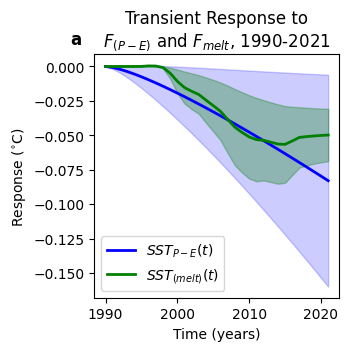

In [9]:
# Plot Fig. 3a 

fig, ax = plt.subplots(figsize=[3.16,3.16])

plt.plot(years,transient_response_fafwater,color='blue', linestyle='-', linewidth=2,label='$SST_{P-E}(t)$')
plt.fill_between(years,transient_response_fafwater-transient_error_fafwater\
                 ,transient_response_fafwater+transient_error_fafwater,color='blue', alpha=0.2)

plt.plot(years,transient_response_antwater,color='green', linestyle='-', linewidth=2,label='$SST_{(melt)}(t)$')
plt.fill_between(years,transient_response_antwater-transient_error_antwater\
                 ,transient_response_antwater+transient_error_antwater,color='green',alpha=.3)


plt.xlabel('Time (years)')
plt.ylabel(r'Response ($^{\circ}$C)')
plt.title(r'Transient Response to' + '\n'+ '$F_{(P-E)}$ and $F_{melt}$, 1990-2021')
ax.text(-.1, 1.1, 'a', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', va='top')
plt.legend()

plt.show() 

In [10]:
# Now we need to get historical SST time series as simulated in CMIP6 
# The data will be obtained from the intake_esm datastore similar to the P-E 
# data in Fig2.ipynb 
# SST variable called tos in saved model output 

url = 'https://storage.googleapis.com/cmip6/pangeo-cmip6.json'
col = intake.open_esm_datastore(url)

df_base = col.search(
    activity_id=['CMIP','ScenarioMIP'],
    table_id = ['Omon'],
    variable_id = ['tos'],
    experiment_id = ['historical','ssp585'],
    source_id = [
    "ACCESS-CM2",
    "ACCESS-ESM1-5",
    "AWI-ESM-1-REcoM",
    "CanESM5",
    "CAS-ESM2-0",
    "CESM2",
    "FGOALS-g3",
    "GFDL-CM4",
    "GFDL-ESM2M",
    "GFDL-ESM4",
    "GISS-E2-1-G",
    "HadGEM3-GC31-LL",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
    "MRI-ESM2-0"
],
    member_id = ['r1i1p1f1','r1i1p1f3','r1i1p5f1','r10i1p1f1']

)

# create xarray dictionaries for each search query 
kwargs = {
    'zarr_kwargs':{
        'use_cftime':True
    },
    'aggregate':False,
    
    'preprocess':combined_preprocessing
}

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dict_tos = df_base.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [11]:
# subset to the time period of interest 

historical_start = '1979-01-01'
historical_end = '2014-12-30'
ssp585_start = '2015-01-01'
ssp585_end = '2021-12-30'

# Adjust time range for historical and ssp585 data in the original dictionary
for key, value in dict_tos.items():
    # Check if the item is related to historical data
    if 'historical' in key:
        dict_tos[key] = value.sel(time=slice(historical_start, historical_end))
    # Check if the item is related to ssp585 data
    elif 'ssp585' in key:
        dict_tos[key] = value.sel(time=slice(ssp585_start, ssp585_end))
        
# splice the experiments together 
dict_tos = concat_experiments(dict_tos)

# removed unneeded models and check for correct number 
del dict_tos['GISS-E2-1-G.gn.Omon.r1i1p1f1.tos']
del dict_tos['CESM2.gn.Omon.r1i1p1f1.tos']
del dict_tos['GISS-E2-1-G.gn.Omon.r1i1p1f3.tos']
del dict_tos['GISS-E2-1-G.gn.Omon.r10i1p1f1.tos']
del dict_tos['ACCESS-ESM1-5.gn.Omon.r10i1p1f1.tos']
del dict_tos['MPI-ESM1-2-LR.gn.Omon.r10i1p1f1.tos']
del dict_tos['MIROC6.gn.Omon.r10i1p1f1.tos']
del dict_tos['CanESM5.gn.Omon.r10i1p1f1.tos']
del dict_tos['MPI-ESM1-2-HR.gn.Omon.r10i1p1f1.tos']
del dict_tos['CAS-ESM2-0.gn.Omon.r1i1p1f1.tos']
del dict_tos['CESM2.gr.Omon.r1i1p1f1.tos']
del dict_tos['CESM2.gr.Omon.r10i1p1f1.tos']
del dict_tos['MRI-ESM2-0.gr.Omon.r1i1p1f1.tos']
del dict_tos['GFDL-ESM4.gr.Omon.r1i1p1f1.tos']
del dict_tos['GFDL-CM4.gr.Omon.r1i1p1f1.tos']
print("Number of items in the combined dictionary:", len(dict_tos))

Number of items in the combined dictionary: 13


In [12]:
# correct for the incorrect units in the ssp585 component of GISS model (deg. K vs. deg. C) 

dict_tos['GISS-E2-1-G.gn.Omon.r1i1p5f1.tos'].tos[:,:,432:,:,:]=\
dict_tos['GISS-E2-1-G.gn.Omon.r1i1p5f1.tos'].tos[:,:,432:,:,:]-273

In [13]:
%%time 

# calculate four sets of time series, the unadjusted CMIP6 SST trend, and the SST trends
# adjusted by the transient responses shown in Fig. 3a (first, second, and both) 

########################################################################

# regrid to standard rectilinear 1x1 grid
def regrid_dataarray(dataset,data):
    ds_out = xe.util.grid_global(1,1)
    regridder = xe.Regridder(dataset,ds_out, 'bilinear',periodic=True,\
    ignore_degenerate=True)
    return regridder(data)

########################################################################

# subset xarray dataarray by latitude, assumes coordinates follow the conventions of regrid_dataarray output. 
def subset_bylatitude(data,south_bound,north_bound):
    data_SO = data.sel\
    (y=slice(np.abs(data.lat[:,0].values - (south_bound)).argmin(),\
    np.abs(data.lat[:,0].values - (north_bound)).argmin()))
    return data_SO

########################################################################

# spatially average CMIP6 Omon field over specified latitudes
# assumes spatial average is conducted over all longitudes
# Assumes regrid_dataarray function is already applied
def spatial_average(inputdata,southlat,northlat):
    data_subset = subset_bylatitude\
    (inputdata,south_bound=southlat,north_bound=northlat)
    lat_subset = data_subset.lat
    coslat = np.cos(np.deg2rad(lat_subset))
    weight_factor = coslat / coslat.mean(dim='y')
    data_average = \
    (data_subset * weight_factor).mean(dim=('x', 'y'),skipna=True)
    return data_average

########################################################################

trends_CMIP6 = []
trends_CMIP6_MW = []
trends_CMIP6_FW = []
trends_CMIP6_both = []

# calculate trends in Deg. C per decade 

years = np.linspace(1990,2021,32)
for ds in dict_tos.values():
    timeseries_CMIP6 = spatial_average(regrid_dataarray(ds,ds.tos),-65,-50).coarsen(time=12).mean()[0,0,11:]
    
    trend_CMIP6 = linregress(years,timeseries_CMIP6)[0]*10
    
    trend_CMIP6_MW = linregress(years,timeseries_CMIP6+transient_response_antwater)[0]*10
    
    trend_CMIP6_FW = linregress(years,timeseries_CMIP6+transient_response_fafwater)[0]*10
    
    trend_CMIP6_both = \
    linregress(years,timeseries_CMIP6+transient_response_antwater+transient_response_fafwater)[0]*10

    trends_CMIP6.append(trend_CMIP6)
    trends_CMIP6_MW.append(trend_CMIP6_MW)
    trends_CMIP6_FW.append(trend_CMIP6_FW)
    trends_CMIP6_both.append(trend_CMIP6_both)
    print('Finished model: ', ds.attrs['parent_source_id'])

Finished model:  FGOALS-g3
Finished model:  ACCESS-CM2
Finished model:  GFDL-ESM4
Finished model:  ACCESS-ESM1-5
Finished model:  GFDL-CM4
Finished model:  CanESM5
Finished model:  CESM2
Finished model:  MRI-ESM2-0
Finished model:  MPI-ESM1-2-HR
Finished model:  HadGEM3-GC31-LL
Finished model:  GISS-E2-1-G
Finished model:  MIROC6
Finished model:  MPI-ESM1-2-LR
CPU times: user 11min 22s, sys: 2min 5s, total: 13min 27s
Wall time: 14min 53s


In [41]:
dict_tos.keys()

dict_keys(['FGOALS-g3.gn.Omon.r1i1p1f1.tos', 'ACCESS-CM2.gn.Omon.r1i1p1f1.tos', 'GFDL-ESM4.gn.Omon.r1i1p1f1.tos', 'ACCESS-ESM1-5.gn.Omon.r1i1p1f1.tos', 'GFDL-CM4.gn.Omon.r1i1p1f1.tos', 'CanESM5.gn.Omon.r1i1p1f1.tos', 'CESM2.gn.Omon.r10i1p1f1.tos', 'MRI-ESM2-0.gn.Omon.r1i1p1f1.tos', 'MPI-ESM1-2-HR.gn.Omon.r1i1p1f1.tos', 'HadGEM3-GC31-LL.gn.Omon.r1i1p1f3.tos', 'GISS-E2-1-G.gn.Omon.r1i1p5f1.tos', 'MIROC6.gn.Omon.r1i1p1f1.tos', 'MPI-ESM1-2-LR.gn.Omon.r1i1p1f1.tos'])

In [14]:
# the spatially averaged time series of observed Southern Ocean SST (NOAASSTv5 product) is pre-processed 
# similar to the time series of ERA5 P-E in Fig2.ipynb, but spatially averaged over 65S to 50S 
# file contains monthly averages 

data_path = os.path.join(root_dir,"Source_Data")
os.chdir(data_path)
NOAA_SST_timeseries = xr.open_dataset('NOAASSTV5_timeseries_monthly.nc').__xarray_dataarray_variable__

# Calculate anomalies relative to the 1979-1989 baseline
SST_anoms_obs = \
NOAA_SST_timeseries.sel(time=slice('1990', '2021')) - NOAA_SST_timeseries.sel(time=slice('1979', '1989')).mean(dim='time')

SST_anoms_obs = SST_anoms_obs.coarsen(time=12).mean()

# get historical observed SST trend and standard error for Southern Ocean 
trend_NOAASSTV5, _, _, _, stderr_NOAASSTV5 = linregress(years, SST_anoms_obs)
print('Observed SST trend and standard error (Deg. C): ', trend_NOAASSTV5,stderr_NOAASSTV5)

Observed SST trend and standard error (Deg. C):  -0.0023856265648763866 0.0019431109415899016


Boxplot 1 (Dataset: _child0):
Median: 0.05988386450850952
Q1: 0.020500389477945895
Q3: 0.12670564347212687
Min: 0.04966122932190397
Max: 0.10277184741624894
Boxplot 2 (Dataset: _child6):
Median: 0.032245471753167665
Q1: -0.007138003277395914
Q3: 0.09906725071678503
Min: 0.022022836566562117
Max: 0.07513345466090708
Boxplot 3 (Dataset: _child12):
Median: 0.03680066157759403
Q1: -0.0025828134529695935
Q3: 0.10362244054121136
Min: 0.026578026390988472
Max: 0.07968864448533344
Boxplot 4 (Dataset: _child18):
Median: 0.009162268822252179
Q1: -0.03022120620831141
Q3: 0.07598404778586955
Min: -0.001060366364353378
Max: 0.05205025172999162


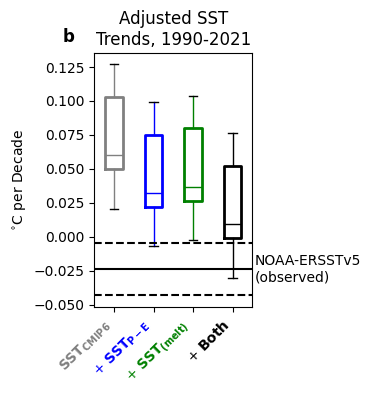

In [15]:
# plot Fig. 3b 

########################################################################

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=[3.16,3.91])
plt.subplots_adjust(left=0.2, right=0.7, bottom=0.2, top=0.85)  # Adjust the margins as needed

########################################################################

# Adding a boxplot to the axis and setting labels for each boxplot
data = [trends_CMIP6, trends_CMIP6_FW, trends_CMIP6_MW, trends_CMIP6_both]
# Colors for each box and whisker plot
colors = ['grey', 'blue', 'green', 'black']

########################################################################

# Adding a boxplot to the axis and setting labels for each boxplot
boxplot = ax.boxplot(data, patch_artist=False,showfliers=False)

# Setting colors for each box and whisker plot
for i, (box, color) in enumerate(zip(boxplot['boxes'], colors)):
    box.set_color(color)
    box.set_linewidth(2)  # Adjust the edge width
    boxplot['whiskers'][i*2].set_color(color)  # Adjust the whisker color
    boxplot['whiskers'][i*2+1].set_color(color)  # Adjust the whisker color
    boxplot['medians'][i].set_color(color)  # Adjust the median color

########################################################################

# Printing the parameters associated with each boxplot
for i, box in enumerate(boxplot['boxes']):
    print(f"Boxplot {i+1} (Dataset: {box.get_label()}):")
    print(f"Median: {boxplot['medians'][i].get_ydata()[0]}")
    print(f"Q1: {boxplot['whiskers'][i*2].get_ydata()[1]}")
    print(f"Q3: {boxplot['whiskers'][i*2+1].get_ydata()[1]}")
    print(f"Min: {boxplot['whiskers'][i*2].get_ydata()[0]}")
    print(f"Max: {boxplot['whiskers'][i*2+1].get_ydata()[0]}")

########################################################################

# Adding horizontal lines for observed SST 
ax.axhline(trend_NOAASSTV5*10, color='k')
ax.axhline((trend_NOAASSTV5 + stderr_NOAASSTV5)*10, color='k', linestyle='dashed')
ax.axhline((trend_NOAASSTV5 - stderr_NOAASSTV5)*10, color='k', linestyle='dashed')

# title observed SST 
ax.text(4.55, trend_NOAASSTV5*10 , 'NOAA-ERSSTv5\n(observed)', verticalalignment='center')

########################################################################

# Setting the x-axis labels
xtick_labels = [
    r'$\bf{SST_{CMIP6}}$',
    r'+ $\bf{SST_{P-E}}$',
    r'+ $\bf{SST_{(melt)}}$',
    r'+ $\bf{Both}$']
for label, color in zip(ax.get_xticklabels(), colors):
    label.set_color(color)
ax.set_xticklabels(xtick_labels,rotation=45, ha='right')

ax.set_title(r'Adjusted SST' + '\n'+ 'Trends, 1990-2021')
ax.set_ylabel(r'$^{\circ}$C per Decade')
ax.text(-.2, 1.1, 'b', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', va='top')

########################################################################

plt.show()

In [23]:
# Calculate median bias corrections and intermodel spread. 

bias = 0.05988386450850952-(trend_NOAASSTV5*10)
PE_adjust_bias_median = 0.032245471753167665-(trend_NOAASSTV5*10)
PE_adjust_bias_all = (trends_CMIP6_FW-(trend_NOAASSTV5*10))
print(bias)
print(1-(PE_adjust_bias_median/bias))
print(np.std(1-(PE_adjust_bias_all/bias)))

0.08374013015727338
0.3300495557319274
0.7341480232986852


In [24]:
# Calculate median bias corrections and intermodel spread. 

bias = 0.05988386450850952-(trend_NOAASSTV5*10)
melt_adjust_bias_median = 0.03680066157759403-(trend_NOAASSTV5*10)
melt_adjust_bias_all = trends_CMIP6_MW-(trend_NOAASSTV5*10)
print(bias)
print(1-(melt_adjust_bias_median/bias))
print(np.std(1-(melt_adjust_bias_all/bias)))

0.08374013015727338
0.27565281887623827
0.734148023298685


In [37]:
np.std(trends_CMIP6_MW-(trend_NOAASSTV5*10))

np.float64(0.06147765102573686)

In [38]:
np.std(trends_CMIP6-(trend_NOAASSTV5*10))

np.float64(0.06147765102573687)